# step 1:

In this section, essential libraries are imported for deep learning, data handling, preprocessing, model training, evaluation, and experiment tracking.

- **Deep Learning**: Libraries like `torch`, `torch.nn`, and `torch.optim` are utilized for building, training, and optimizing neural networks.
- **Data Handling**: `ImageFolder`, `transforms`, and `DataLoader` are used for loading and preprocessing the dataset.
- **Experiment Tracking**: `wandb` is included to track experiments and visualize metrics.
- **Visualization**: `matplotlib` and `numpy` help in visualizing data and results during the training process.
- **Utilities**: `SimpleNamespace` is used to manage configurations, and `random` is used for generating random samples or operations.

These libraries support the entire workflow, from model creation to evaluation and tracking.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import wandb
from types import SimpleNamespace
import random
import getpass
from torchvision import models

# Step 2:

### Function: `pretrain_resnet50`

This function customizes the freezing of layers in a pre-trained ResNet50 model, allowing for different strategies to control which layers are fine-tuned during training.

#### Parameters:
- **`strategy`** (str): Specifies how layers are frozen:
  - `'freeze_last'`: Freezes all layers except the fully connected (fc) layer.
  - `'freeze_k_percent'`: Freezes a percentage of layers based on `freeze_percent`.
  - `'freeze_except_bn_and_fc'`: Freezes all layers except batch normalization and fc layers.
  
- **`freeze_percent`** (float, optional): The percentage of layers to freeze (only for `'freeze_k_percent'` strategy).

#### How It Works:
1. Loads the pre-trained ResNet50 model.
2. Modifies the output layer to match the number of classes (10).
3. Applies the specified freezing strategy:
   - **`'freeze_last'`**: Freezes all layers except the fc layer.
   - **`'freeze_k_percent'`**: Freezes a percentage of layers.
   - **`'freeze_except_bn_and_fc'`**: Freezes all layers except batch normalization and fc.
4. Moves the model to the specified device (CPU or GPU).
5. Returns the modified model.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def pretrain_resnet50(strategy, freeze_percent=0.0):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_classes = 10
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if strategy == 'freeze_last':
        for name, param in model.named_parameters():
            if not name.startswith('fc'):
                param.requires_grad = False

    elif strategy == 'freeze_k_percent':
        params = list(model.named_parameters())
        num_to_freeze = int(len(params) * freeze_percent)
        for idx, (name, param) in enumerate(params):
            param.requires_grad = idx >= num_to_freeze

    elif strategy == 'freeze_except_bn_and_fc':
        for name, param in model.named_parameters():
            if 'bn' in name or name.startswith('fc'):
                param.requires_grad = True
            else:
                param.requires_grad = False

    else:
        raise ValueError("Invalid strategy. Choose from 'freeze_last', 'freeze_k_percent', or 'freeze_except_bn_and_fc'.")

    model.to(device)
    return model

# Step 3:

### Visualizing Random Images from a Class

This code randomly selects a class from the training dataset directory and displays 10 random images from that class. The purpose is to visually inspect the images and verify the diversity and quality of the images in a particular class.

-  A random class is selected from the available class folders.
- 10 random images are chosen from that class folder.
- The images are displayed in a row, with the class name as the title above the images.

This can be useful for quickly examining the contents of your dataset and ensuring the images are correctly labeled.


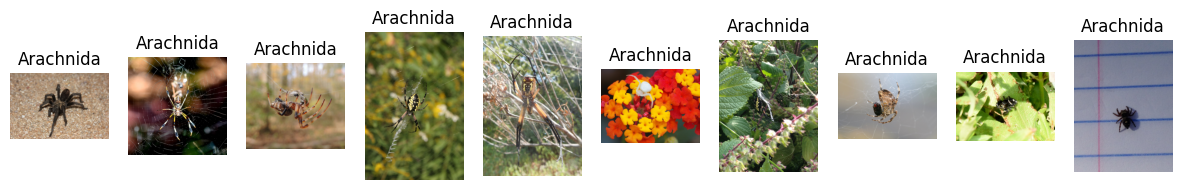

In [ ]:
train_data_dir = '/kaggle/input/12kimage/inaturalist_12K/train'
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
class_folders = os.listdir(train_data_dir)
random_class = random.choice(class_folders)
class_path = os.path.join(train_data_dir, random_class)
image_files = random.sample(os.listdir(class_path), 10)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(random_class)

plt.show()

# Step 4:

### Data Loading with Optional Augmentation

The `data_load` function loads the training dataset, applies optional augmentation, and splits the data into training and validation sets.

#### Parameters:
- **`train_data_dir`** (str): Path to the training images directory.
- **`data_augmentation`** (str): Apply augmentation if `'Yes'` (random cropping, flip, jitter, rotation), otherwise `'No'`.

#### Steps:
1. **Base Transformations**: Resizes, converts to tensor, and normalizes images.
2. **Data Augmentation (Optional)**: Applies augmentation techniques if `'Yes'`.
3. **Dataset Creation**: Uses `ImageFolder` to load images organized by class.
4. **Data Splitting**: Splits data into 80% training and 20% validation sets.
5. **Data Loaders**: Returns `train_loader` and `val_loader` for batching.
6. **Returns**: DataLoaders, dataset, and split indices for training and validation.



In [ ]:
def data_load(train_data_dir, data_augmentation):
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

    augmentation_transforms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20)
    ]

    transform_img = transforms.Compose(augmentation_transforms + base_transforms) if data_augmentation == 'Yes' else transforms.Compose(base_transforms)

    dataset = ImageFolder(root=train_data_dir, transform=transform_img)
    train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))
    return train_loader, val_loader,dataset,train_indices,val_indices

### Loading and Inspecting Dataset Information

This code block loads the training and validation datasets using the `data_load` function, which applies optional data augmentation. It then prints useful information about the dataset, including the total number of images, the number of images in the training and validation datasets, and the number of batches in both training and validation data loaders.

#### Steps:
1. **Load Data**: The `data_load` function is called with the `train_data_dir` and `data_augmentation="Yes"`, which loads the dataset and applies the specified transformations, including augmentation (random cropping, flipping, jitter, and rotation).
   
2. **Print Dataset Information**:
   - The total number of images in the dataset is printed.
   - The number of images in the training dataset (`train_indices`) and the validation dataset (`val_indices`) are printed.
   - The number of batches in the training and validation data loaders (`train_loader` and `val_loader`) is printed.


In [ ]:
train_loader,val_loader,dataset,train_indices, val_indices=data_load(train_data_dir, data_augmentation="Yes")
print(f"Total images in dataset: {len(dataset)}")
print(f"Total images in training dataset: {len(train_indices)}")
print(f"Total images in validation dataset: {len(val_indices)}")
print(f"Number of batches in training data: {len(train_loader)}")
print(f"No of batches in validation data: {len(val_loader)}")

Total images in dataset: 9999
Total images in training dataset: 7999
Total images in validation dataset: 2000
Number of batches in training data: 250
No of batches in validation data: 63


### Inspecting Training and Validation Sample Information

This code block retrieves and prints information about the training and validation batches. It first calculates the total number of training and validation samples (batches) in the data loaders, then fetches a sample batch of images and labels to inspect their shapes.

1. **Calculate Number of Training and Validation Batches**:
   - `train_samples` holds the total number of training batches (i.e., how many times the training dataset is split into batches).
   - `val_samples` holds the total number of validation batches.
   
2. **Fetch a Sample Batch**:
   - `train_images, train_labels = next(iter(train_loader))`: This line retrieves the first batch of images and their corresponding labels from the training data loader.
   - `val_images, val_labels = next(iter(val_loader))`: This line retrieves the first batch of images and their corresponding labels from the validation data loader.

3. **Print Information**:
   - The total number of training samples (`train_samples`) and validation samples (`val_samples`) is printed.
   - The shape of the first training batch (`train_images.shape`) and the first validation batch (`val_images.shape`) is printed, giving insights into the dimensions of the images.



In [ ]:
train_samples = len(train_loader)
val_samples = len(val_loader)
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
print(f"Total training samples: {train_samples}")
print(f"training Image shape: {train_images.shape}")
print(f"Total val samples: {val_samples}")
print(f"val Image shape: {val_images.shape}")

Total training samples: 250
training Image shape: torch.Size([32, 3, 224, 224])
Total val samples: 63
val Image shape: torch.Size([32, 3, 224, 224])


# Step 5:
### Model Training with WandB Logging

The `model_training` function trains a model on the training dataset, evaluates on the validation dataset, and logs the performance to Weights & Biases (WandB), if enabled. It also plots the accuracy over epochs after training.

#### Parameters:
- **`model`**: The model to train.
- **`train_data`**: The training data loader.
- **`val_data`**: The validation data loader.
- **`epochs`** (int): Number of training epochs (default: 10).
- **`device`** (str): Device for training (`'cuda'` or `'cpu'`).
- **`lr`** (float): Learning rate (default: 0.001).
- **`use_wandb`** (bool): Enable WandB logging (default: `True`).

#### Steps:
1. **Initialize Model**: Moves the model to the specified device.
2. **Loss & Optimizer**: Sets up `CrossEntropyLoss` and Adam optimizer.
3. **WandB Setup**: Logs training details if `use_wandb` is `True`.
4. **Training Loop**: Computes loss and accuracy for each batch and updates model weights.
5. **Validation Loop**: Calculates validation accuracy without weight updates.
6. **WandB Logging**: Logs training and validation metrics after each epoch.
7. **Training Summary**: Plots the training and validation accuracy.
8. **Output**: Returns the trained model.



In [ ]:
def model_training(model, train_data, val_data, epochs=10, device='cuda', lr=0.001, use_wandb=True):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if use_wandb:
        wandb.init(project="DL_CNN", config={"epochs": epochs, "lr": lr})
        wandb.watch(model, log="all")

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_data:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_data)
        train_accuracy = 100 * correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_acc_list.append(val_accuracy)

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'Train loss': avg_loss,
                'Train accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            })

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    if use_wandb:
        wandb.finish()

    print("Training complete!")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_acc_list, label="Training Accuracy", marker='o',color="blue")
    plt.plot(range(1, epochs + 1), val_acc_list, label="Validation Accuracy", marker='o',color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
    return model

# Step 6:
 Strategy 1: Freeze all layers except classifier

In [ ]:
model1 = pretrain_resnet50(strategy='freeze_last')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Epoch 1/5 | Train Loss: 1.3133 | Train Acc: 62.52% | Val Acc: 71.25%
Epoch 2/5 | Train Loss: 0.9155 | Train Acc: 72.43% | Val Acc: 73.45%
Epoch 3/5 | Train Loss: 0.8354 | Train Acc: 74.13% | Val Acc: 75.55%
Epoch 4/5 | Train Loss: 0.7873 | Train Acc: 74.77% | Val Acc: 74.80%
Epoch 5/5 | Train Loss: 0.7493 | Train Acc: 75.58% | Val Acc: 75.50%
Training complete!


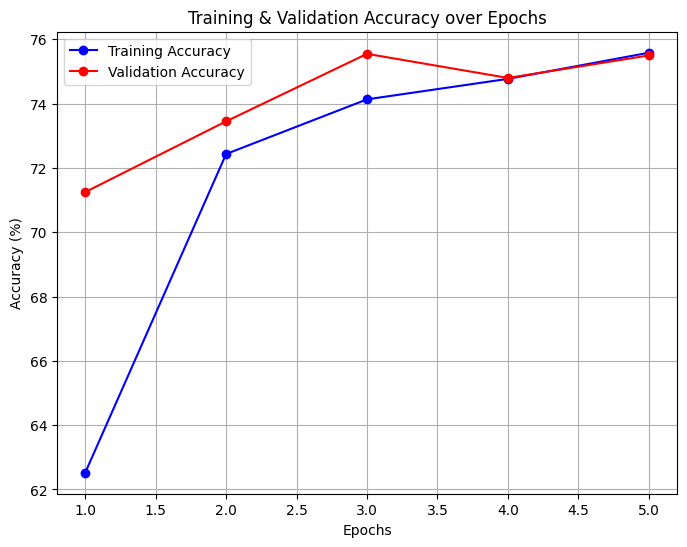

In [ ]:
model_training(model1, train_loader, val_loader, epochs=5, device='cuda', lr=0.001, use_wandb=False)

Strategy 2: Freeze first 25% of parameters

In [ ]:
model2 = pretrain_resnet50(strategy='freeze_k_percent', freeze_percent=0.25)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Epoch 1/5 | Train Loss: 1.5607 | Train Acc: 46.83% | Val Acc: 50.15%
Epoch 2/5 | Train Loss: 1.3118 | Train Acc: 55.62% | Val Acc: 54.20%
Epoch 3/5 | Train Loss: 1.2036 | Train Acc: 59.04% | Val Acc: 56.40%
Epoch 4/5 | Train Loss: 1.1281 | Train Acc: 61.45% | Val Acc: 57.90%
Epoch 5/5 | Train Loss: 1.0710 | Train Acc: 64.02% | Val Acc: 59.20%
Training complete!


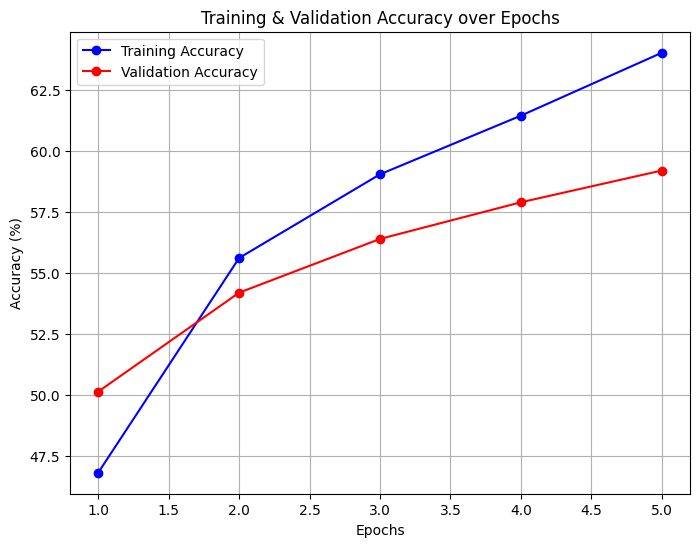

In [ ]:
model_training(model2, train_loader, val_loader, epochs=5, device='cuda', lr=0.001, use_wandb=False)

Strategy 3: Freeze all except BatchNorm and classifier

In [ ]:
model3 = pretrain_resnet50(strategy='freeze_except_bn_and_fc')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Epoch 1/5 | Train Loss: 0.5899 | Train Acc: 79.88% | Val Acc: 79.70%
Epoch 2/5 | Train Loss: 0.5651 | Train Acc: 81.51% | Val Acc: 79.45%
Epoch 3/5 | Train Loss: 0.5483 | Train Acc: 81.71% | Val Acc: 79.55%
Epoch 4/5 | Train Loss: 0.5170 | Train Acc: 83.04% | Val Acc: 80.95%
Epoch 5/5 | Train Loss: 0.5085 | Train Acc: 82.92% | Val Acc: 80.30%
Training complete!


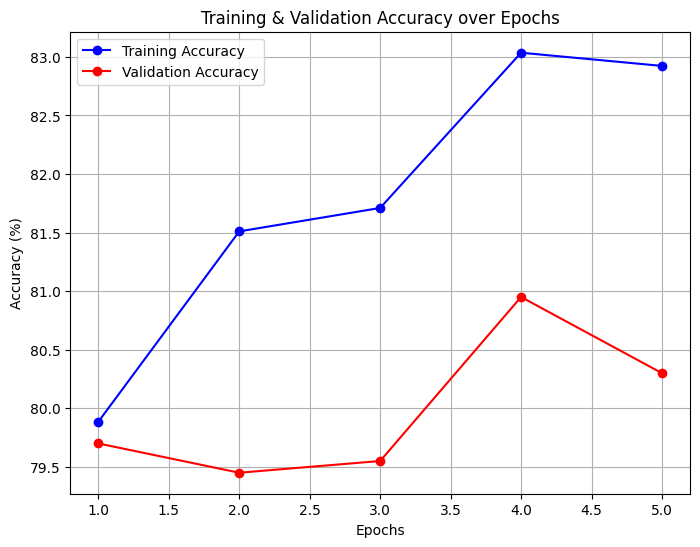

In [ ]:
model_training(model3, train_loader, val_loader, epochs=5, device='cuda', lr=0.001, use_wandb=False)

# Step 7:

In [ ]:
model_final = pretrain_resnet50(strategy='freeze_except_bn_and_fc')

Epoch 1/30 | Train Loss: 1.1613 | Train Acc: 64.50% | Val Acc: 73.60%
Epoch 2/30 | Train Loss: 0.7606 | Train Acc: 75.42% | Val Acc: 76.85%
Epoch 3/30 | Train Loss: 0.6816 | Train Acc: 77.91% | Val Acc: 77.40%
Epoch 4/30 | Train Loss: 0.6232 | Train Acc: 79.21% | Val Acc: 79.50%
Epoch 5/30 | Train Loss: 0.6206 | Train Acc: 79.66% | Val Acc: 79.25%
Epoch 6/30 | Train Loss: 0.5838 | Train Acc: 80.39% | Val Acc: 79.60%
Epoch 7/30 | Train Loss: 0.5498 | Train Acc: 81.52% | Val Acc: 80.00%
Epoch 8/30 | Train Loss: 0.5508 | Train Acc: 81.94% | Val Acc: 81.15%
Epoch 9/30 | Train Loss: 0.5233 | Train Acc: 82.35% | Val Acc: 80.40%
Epoch 10/30 | Train Loss: 0.5098 | Train Acc: 82.87% | Val Acc: 80.65%
Epoch 11/30 | Train Loss: 0.5046 | Train Acc: 83.11% | Val Acc: 80.35%
Epoch 12/30 | Train Loss: 0.4903 | Train Acc: 83.19% | Val Acc: 80.45%
Epoch 13/30 | Train Loss: 0.4891 | Train Acc: 83.76% | Val Acc: 80.60%
Epoch 14/30 | Train Loss: 0.4669 | Train Acc: 84.50% | Val Acc: 80.15%
Epoch 15/30 | T

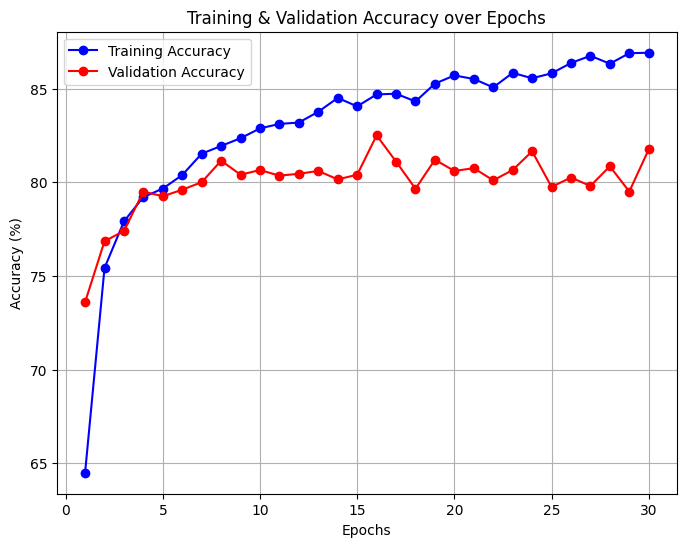

In [ ]:
train_model=model_training(model_final, train_loader, val_loader, epochs=30, device='cuda', lr=0.001, use_wandb=False)

#Step 8:

- Loads validation images from the specified directory (`test_data_dir`)
- Randomly selects a class from the validation data folders
- Samples 10 images from the randomly selected class
- Displays the 10 selected images in a 1x10 grid without axis labels
- Titles each image with the class name


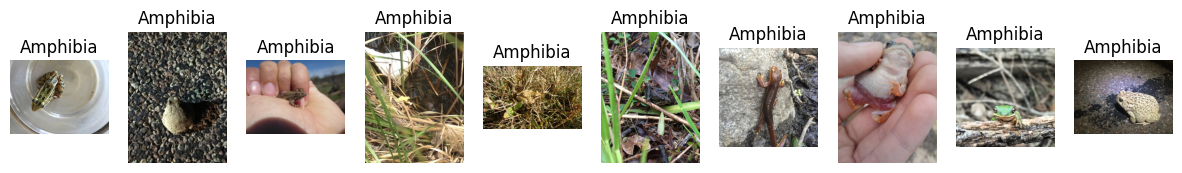

In [ ]:
test_data_dir = '/kaggle/input/12kimage/inaturalist_12K/val'
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
class_folders = os.listdir(train_data_dir)
random_class = random.choice(class_folders)
class_path = os.path.join(train_data_dir, random_class)
image_files = random.sample(os.listdir(class_path), 10)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(random_class)

plt.show()

# Step 9:

- Defines the function `test_data_load` to load and preprocess the test dataset
- Applies a series of transformations (resizing, normalization, and optional data augmentation)
- Augmentation includes random resized crop, horizontal flip, color jitter, and random rotation
- Returns a DataLoader for the test dataset to batch the images for evaluation
- Calls the function with `data_augmentation` set to "No"
- Prints the total number of images in the test dataset and the number of batches in the test DataLoader

In [ ]:
def test_data_load(test_data_dir, data_augmentation):
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    augmentation_transforms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20)
    ]
    transform_img = transforms.Compose(augmentation_transforms + base_transforms) if data_augmentation == 'Yes' else transforms.Compose(base_transforms)
    test_indices = ImageFolder(root=test_data_dir, transform=transform_img)
    test_loader = DataLoader(test_indices, batch_size=32)
    return test_loader,test_indices

In [ ]:
test_loader,test_indices=test_data_load(test_data_dir, data_augmentation="No")
print(f"Total images in test dataset: {len(test_indices)}")
print(f"Total images  in test dataset: {len(test_loader)}")

Total images in test dataset: 2000
Total images  in test dataset: 63


# step 10:

- Defines a function `test` to evaluate the model's performance on the test dataset
- Switches the model to evaluation mode using `model.eval()`
- Initializes counters for correct predictions and total samples
- Loops over the test data and performs predictions without calculating gradients (`torch.no_grad()`)
- Calculates the number of correct predictions and the total number of samples
- Computes the test accuracy as the percentage of correct predictions
- Prints and returns the test accuracy

In [ ]:
def test(model, test_data, device="cpu"):
    model.to(device)
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

In [ ]:
test(train_model,test_loader,'cuda')

Test Accuracy: 86.25%


86.25

# Step 11:

- Defines the `plot_predictions_grid` function to visualize the model's predictions on a subset of the dataset
- Takes the following parameters:
  - `model`: The trained model to make predictions
  - `dataset`: The dataset containing images and their labels
  - `device`: The device (CPU or GPU) where the model is loaded
  - `num_images`: Number of images to display (default is 30)
- The function:
  - Sets the model to evaluation mode using `model.eval()`
  - Randomly selects `num_images` indices from the dataset
  - Creates a grid of subplots to display the images and their predicted vs. true labels
  - For each image:
    - Loads the image and its true label
    - Runs the image through the model to get the predicted label
    - Converts the image from tensor format to NumPy array for plotting
    - Displays the image along with its predicted and true labels in the grid
  - Tightens the layout and shows the grid of images with predictions

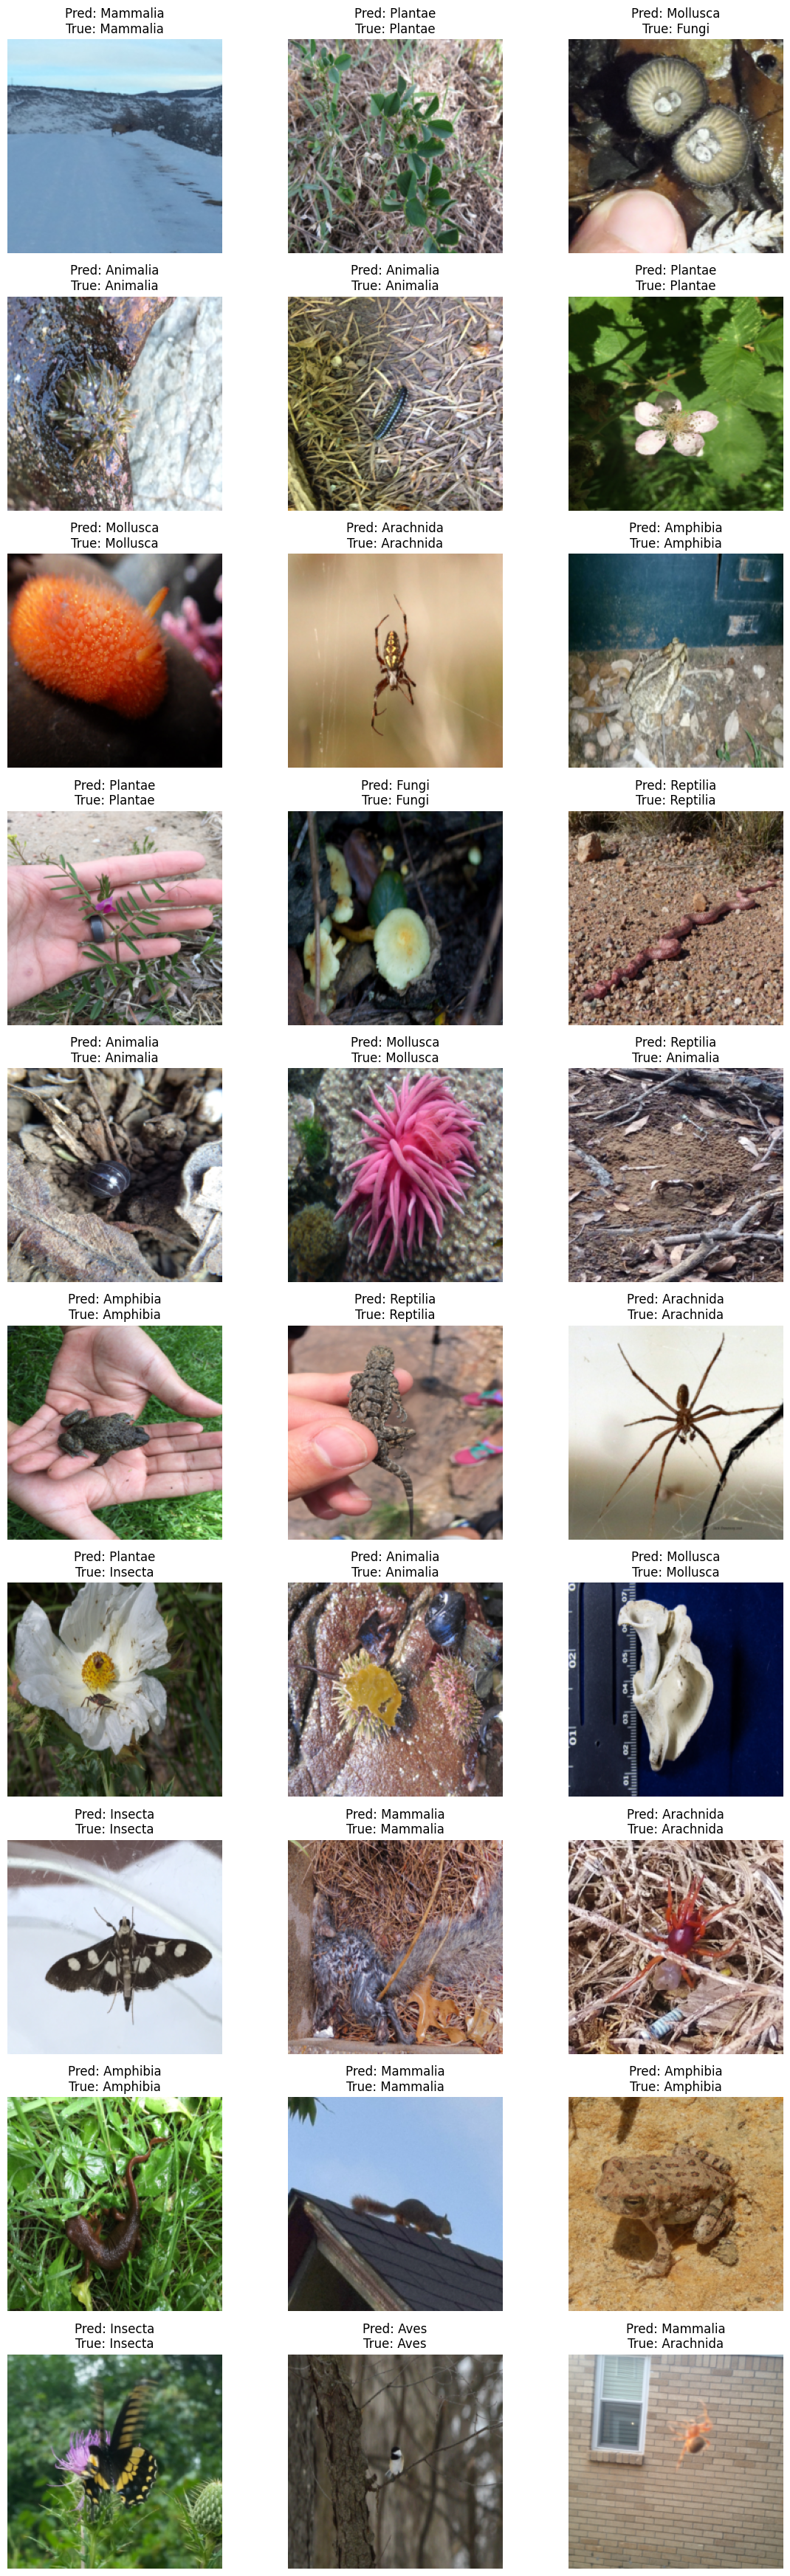

In [ ]:
def plot_predictions_grid(model, dataset, device, num_images=30):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(10, 3, figsize=(12, 35))

    for ax, idx in zip(axes.flatten(), indices):
        img, true_label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            _, pred_label = torch.max(output, 1)

        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * 0.5) + 0.5

        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(f"Pred: {dataset.classes[pred_label.item()]}\nTrue: {dataset.classes[true_label]}")

    plt.tight_layout()
    plt.show()

plot_predictions_grid(train_model, test_indices, device)